In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dgl
import networkx as nx
import torch
import torch.nn.functional as F
import geopy.distance
import tqdm
from sklearn.preprocessing import StandardScaler

import torch.nn as nn

In [2]:
data_dir = "./data/"

In [3]:
centroids = pd.read_csv(data_dir + 'district wise centroids.csv')

In [4]:
districts = pd.read_csv(data_dir + 'districts.csv')

In [5]:
df = districts[districts['District'] == 'Ahmedabad']
cases = df[df['Date'] > '2021-03-01']['Confirmed'].values

In [6]:
doubles = ['Aurangabad', 'Bilaspur', 'Hamirpur', 'Pratapgarh', 'Balrampur', 'Unknown', 
          'Airport Quarantine', 'Evacuees', 'Other Region', 'Other State', 'Others', 'East Garo Hills', 'South Garo Hills']

In [7]:
dists = districts['District'].unique()

In [8]:
for double in doubles:
    loc = np.nonzero(dists == double)[0][0]
    dists = np.delete(dists, loc)

In [9]:
location_dict = {}
final_dists = []

In [10]:
for dist in dists:
    if len(centroids[centroids['District'] == dist]) == 1:
        lat = centroids[centroids['District'] == dist]['Latitude']
        long = centroids[centroids['District'] == dist]['Longitude']
        location_dict[dist] = (float(lat), float(long))

        df = districts[districts['District'] == dist]
        
        cases = df[df['Date'] > '2020-06-23']
        cases = cases[cases['Date'] < '2020-12-03']['Confirmed'].values
        cases_test = df[df['Date'] > '2021-03-01']['Confirmed'].values
    
        if len(cases) == 162 and len(cases_test) == 89:
            location_dict[dist] = (float(lat), float(long), cases, cases_test)
            final_dists.append(dist)

In [156]:
g = nx.Graph()

for i in tqdm.tqdm(range(len(final_dists))):
    for j in range(len(final_dists)):
        if i != j:
            lat_1 = location_dict[final_dists[i]][0:2]
            lat_2 = location_dict[final_dists[j]][0:2]
            dist = geopy.distance.distance(lat_1, lat_2).km
            g.add_edge(i, j, weight=dist)

100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [01:15<00:00,  5.82it/s]


In [13]:
scaler = StandardScaler()
case_data = scaler.fit_transform(location_dict["Thiruvallur"][2].reshape(-1, 1)).ravel()

In [14]:
loc = int(0.7 * 162)
train = case_data[:loc]
#test = location_dict["Thiruvallur"][3]
test = case_data[loc:]

In [ ]:
train.shape

In [334]:
scaler = StandardScaler()
train = scaler.fit_transform(train.reshape(-1, 1)).ravel()
test = scaler.transform(test.reshape(-1, 1)).ravel()

In [15]:
train = torch.FloatTensor(train).view(-1)
test = torch.FloatTensor(test).view(-1)

In [16]:
def create_input_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [17]:
train_inout_seq = create_input_sequences(train, 7)

In [619]:
train_data, labels = list(zip(*train_inout_seq))
train_data_final = torch.zeros(99, 7)

for i in range(len(train_data)):
    train_data_final[i, :] = train_data[i]
    
labels_final = torch.zeros(99)
for i in range(len(labels)):
    labels_final[i] = labels[i]

TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

In [33]:
class LSTM(nn.Module):
    
    def __init__(self, input_size=1, hidden_layer_size=64, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, 1)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 7, self.hidden_layer_size),
                            torch.zeros(1, 7, self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(-1, len(input_seq),  1), self.hidden_cell)
        #print(lstm_out[-1, :, :].view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out[-1, :, :].view(len(input_seq), -1))
        return predictions[-1]

In [34]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
print(model)

LSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [36]:
epochs = 5

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 7, model.hidden_layer_size),
                             torch.zeros(1, 7, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, seq)
        single_loss.backward()
        optimizer.step()

    if i % 5 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00115487
epoch:   4 loss: 0.0010758762


In [549]:
epochs = 25

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 5 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

RuntimeError: Expected hidden[0] size (1, 14, 32), got [1, 1, 32]

In [37]:
vals = create_input_sequences(test, 7)

In [38]:
inp = [val[0] for val in vals]
out = [val[1] for val in vals]

In [39]:
preds = []
for week in inp:
    preds.append(model(week.view(7, 1, -1))[0])

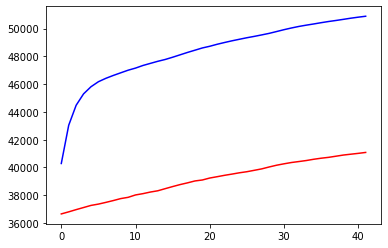

In [40]:
plt.plot(scaler.inverse_transform(preds), c='b')
plt.plot(scaler.inverse_transform(out), c='r')